# Learning the committor for Alanine with distances as inputs
Reference papers: 
- _Kang, Trizio and Parrinello, [Nat Comput Sci](https://doi.org/10.1038/s43588-024-00645-0) (2024), [ArXiv](https://arxiv.org/abs/2401.05279)_
- _Trizio, Kang and Parrinello, [Nat Comput Sci](https://doi.org/10.1038/s43588-025-00799-5) (2025), [ArXiv](https://arxiv.org/abs/2410.17029)_

Prerequisites: committor and transforms tutorials in the tutorial notebooks.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/examples/ex_committor.ipynb)

### Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

def convert_model(model_name, n_input):
    loaded_model = torch.jit.load(model_name).to(torch.device('cpu')).to(torch.float32)
    fake_input = torch.rand(n_input).to(torch.float32)
    loaded_model(fake_input)
    frozen_model = torch.jit.trace(loaded_model, fake_input)
    torch.jit.save(frozen_model, model_name)

# Set seed for reproducibility
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

### Initialize common objects for all iterations
Here we initialize some system-dependent objects that will be used through all the iterations without changes.

**Variables**
- masses vector, can be done using the `initialize_committor_masses` helper function
- number of atoms
- cell size
- temperature of the system
- Boltzmann constant in the right energy units

**Functions**
- Descriptors computation



#### Variables

In [ ]:
from mlcolvar.cvs.committor.utils import initialize_committor_masses 

# initialize the masses vector for the calculation
atomic_masses = initialize_committor_masses(atom_types=[0, 0, 1, 2, 0, 0, 0, 1, 2, 0], 
                                            masses=[12.011, 15.999, 14.007])

# number of atoms
n_atoms=10

# temperature in Kelvin
T = 300 

# simulation cell 
cell = torch.Tensor([3.0233, 3.0233, 3.0233])
print('Cell: ', cell)

# Boltzmann factor in the RIGHT ENERGY UNITS!
kb = 0.0083144621 # kJ/mol
beta = 1/(kb*T)
print(f'Beta: {beta} \n1/beta: {1/beta}')

Cell:  tensor([3.0233, 3.0233, 3.0233])
Beta: 0.4009078751268027 
1/beta: 2.4943386299999997


#### Descriptors calculations
Many common descriptors are already implemented in `mlcolvar.core.transform.descriptors`, a quick general tutorial for computing and combining descriptors with `mlcolvar` can be found [HERE](https://github.com/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/adv_transforms.ipynb).

Here we use all the pairwise distances between the heavy atoms of the molecule with the command `PairwiseDistances`.

In [3]:
from mlcolvar.core.transform import PairwiseDistances

# initialize object to compute distances
ComputeDistances = PairwiseDistances(n_atoms=10, 
                                     PBC=True, 
                                     cell=cell, 
                                     scaled_coords=True)

## Iter 0: Unbiased data only 
In general, we start from unbaised data from the metastable states only.
This allows imposing the correct boundary conditions but is not optimal for applying the variational loss.
As a consequence, our first guess will only be little more than a classifier but it will allow us collecting more configurations that will lead to a much better model in the following iterations.

#### Load data
Here we:
1. load the data, should be done using the `create_from_dataset_from_files` function
2. assign the correct weights and labels, should be done using the `compute_committor_weights` function
3. compute the descriptors from the positions and the corresponding derivatives only once to save time and resources.

The `compute_committor_weights` expect a `bias` input, which is used to compute the correct weights from reweighting of the different trajectories/iterations, as indicated by the `data_groups` key. 
**Indeces 0 and 1 ALWAYS indicate the data that should be used for state A and B in the boundary conditions loss.**

Here, as the simulations are unbiased we initalize `bias` as a bunch of zeros.

In [4]:
from mlcolvar.data import DictModule, DictDataset
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights
from mlcolvar.core.loss.utils.smart_derivatives import SmartDerivatives
 
filenames = ['https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/unbiased_sims/COLVAR_A',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/unbiased_sims/COLVAR_B',
            ]

load_args = [{'start' : 0, 'stop': 10000, 'stride': 5},
             {'start' : 0, 'stop': 10000, 'stride': 5},
            ]           

# load data
dataset, dataframe = create_dataset_from_files(file_names = filenames,
                                               create_labels = True,
                                               filter_args={'regex' : 'p[1-9]\.[abc]|p[1-2][0-9]\.[abc]'},
                                               return_dataframe = True,
                                               load_args=load_args,
                                               verbose = True)

# zeroth iteration should be unbiased, we thus initialize the bias as zero
bias = torch.zeros(len(dataset))

# compute weights
dataset = compute_committor_weights(dataset=dataset, 
                                    bias=bias, 
                                    data_groups=[0, 1], 
                                    beta=beta)

# This makes the computation much faster and less memory consuming.
# 1. We compute the input descriptors and update the dataset --> smart_dataset
# 2. we precompute their derivatives wrt positions --> smart_derivatives
smart_derivatives = SmartDerivatives()
smart_dataset = smart_derivatives.setup(dataset=dataset,
                                        descriptor_function=ComputeDistances,
                                        n_atoms=n_atoms,
                                        separate_boundary_dataset=False, # here we keep it as false as we only have boundary data
                                        descriptors_batch_size=None      # the computation of descriptors and derivatives can also be done in batches
                                      )

# initialize datamodule
datamodule = DictModule(smart_dataset, lengths=[1])

Class 0 dataframe shape:  (2000, 91)
Class 1 dataframe shape:  (2000, 91)

 - Loaded dataframe (4000, 91): ['time', 'phi', 'psi', 'theta', 'ene', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'p1.a', 'p1.b', 'p1.c', 'p2.a', 'p2.b', 'p2.c', 'p3.a', 'p3.b', 'p3.c', 'p4.a', 'p4.b', 'p4.c', 'p5.a', 'p5.b', 'p5.c', 'p6.a', 'p6.b', 'p6.c', 'p7.a', 'p7.b', 'p7.c', 'p8.a', 'p8.b', 'p8.c', 'p9.a', 'p9.b', 'p9.c', 'p10.a', 'p10.b', 'p10.c', 'cell.ax', 'cell.ay', 'cell.az', 'cell.bx', 'cell.by', 'cell.bz', 'cell.cx', 'cell.cy', 'cell.cz', 'walker', 'labels']
 - Descriptors (4000, 30): ['p1.a', 'p1.b', 'p1.c', 'p2.a', 'p2.b', 'p2.c', 'p3.a', 'p3.b', 'p3.c', 'p4.a', 'p4.b', 'p4.c', 'p5.a', 'p5.b', 'p5.c', 'p6.a', 'p6.b', 'p6.c', 'p7.a', 'p7.b'

#### Visualize training set
It is useful to visualize the training set in a space defined by some physical descriptors that can be accessed using the indexing of the `dataframe` we just loaded.
Two useful things to check are the labels of the points and their weights.

Here, for example, we can use the plane defined by the torsional angles $\phi\psi$.

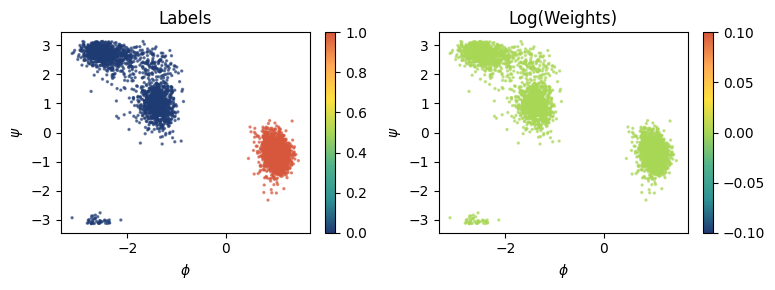

In [5]:
from mlcolvar.utils.plot import paletteFessa

fig, axs = plt.subplots(1,2,figsize=(8,3))

# plot labels
ax = axs[0]
ax.set_title('Labels')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
cp = ax.scatter(dataframe['phi'], dataframe['psi'], c=dataset['labels'], cmap='fessa', s=2, alpha=0.6)
cb = plt.colorbar(cp, ax=ax)
cb.solids.set(alpha=1)

# plot weights
ax = axs[1]
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
ax.set_title('Log(Weights)')
cp = ax.scatter(dataframe['phi'], dataframe['psi'], c=torch.log(dataset['weights']), cmap='fessa', s=2, alpha=0.6)
cb = plt.colorbar(cp, ax=ax)
cb.solids.set(alpha=1)

plt.tight_layout()
plt.show()

#### Initialize model
Here we initialize the model using the `Committor` class and we save the `Sigmoid` activation function that transforms $z \rightarrow q$ as $$ q = \sigma(z)$$ this way, we can easily turn it on and off to access the two quantities.

NB. It is much better to set a learning rate scheduler for the training, `gamma` of 0.99999 (slower decay) or 0.9999 (faster decay) are fine most of the cases, to have a more stable training or a little speedier one, respectively. 

In [ ]:
from mlcolvar.cvs import Committor
import copy

# initialize lr scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR

# create options dictionary
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}, 
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.9999 },
            'nn' : {'activation' : 'tanh'}}

# initialize model
model = Committor(layers=[45, 32, 32, 1],
                         atomic_masses=atomic_masses,
                         alpha=1e1,
                         options=options, 
                         separate_boundary_dataset=False,           # this to separate dataset, by default True, here false as we only have unbiased data
                         descriptors_derivatives=smart_derivatives  # this to speed up derivatives computation
                         )

# copy the last layer sigmoid activation function so we can enable/disable it
Sigmoid = copy.copy(model.sigmoid)

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'descriptors_derivatives' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['descriptors_derivatives'])`.


#### Train model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type           | Params | In sizes | Out sizes
------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | ?        | ?        
1 | nn      | FeedForward    | 2.6 K  | [1, 45]  | [1, 1]   
2 | sigmoid | Custom_Sigmoid | 0      | [1, 1]   | [1, 1]   
------------------------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

[SmartDerivatives] Moving left to cuda:0
[SmartDerivatives] Moving batch_ind to cuda:0
[SmartDerivatives] Moving desc_ind to cuda:0
[SmartDerivatives] Moving scatter_indeces to cuda:0
[SmartDerivatives] To move the preloaded tensors back to cpu, use the `SmartDerivatives.move_to_cpu` method


`Trainer.fit` stopped: `max_epochs=5000` reached.


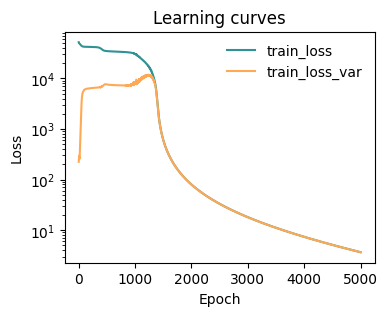

In [ ]:
from mlcolvar.utils.trainer import MetricsCallback
from lightning.pytorch.callbacks import ModelCheckpoint
from mlcolvar.utils.plot import plot_metrics

# define callbacks
metrics = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath="./modelsave/", 
                                      save_top_k=5, 
                                      monitor="train_loss_epoch", 
                                      every_n_epochs=50, 
                                      save_weights_only=True # this makes it faster but is less generic!
                                      ) 

# initialize trainer, for testing the number of epochs is low, change this to something like 5000/100000
trainer = lightning.Trainer(callbacks=[metrics, checkpoint_callback], 
                            max_epochs=5, 
                            logger=False, 
                            enable_checkpointing=True, # disabling or softening checkpointing could make it faster
                            limit_val_batches=0,    # this to skip validation
                            num_sanity_val_steps=0  # this to skip validation
                            )

# fit model
trainer.fit(model, datamodule)

# plot metrics
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1', 'fessa5'],
                  yscale='log',
                  ax = ax)

#### Visualize results
It is better to check what the model is doing on the points we have at hand.
We look at the behaviour of:
- committor CV $z$, deactivating `model.sigmoid=None`
- committor $q$, activating `model.sigmoid=Sigmoid`
- Kolmogorov bias $V_K$, using the `KolmogorovBias` helper class

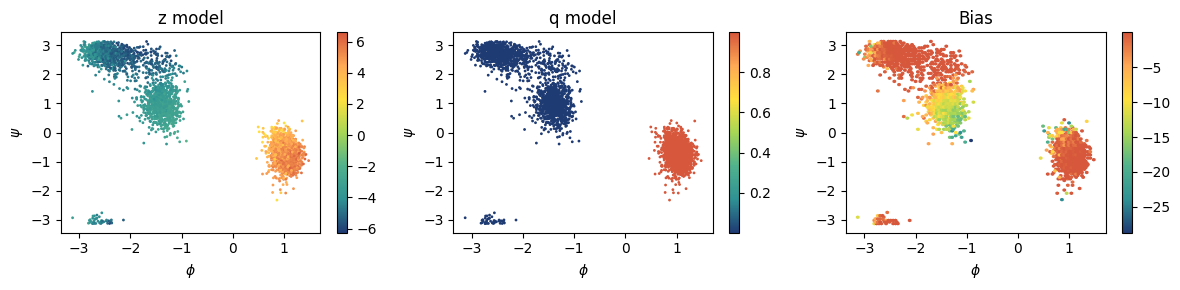

In [8]:
from mlcolvar.cvs.committor.utils import KolmogorovBias

fig, axs = plt.subplots(1,3,figsize=(12,3))

# plot z --> activation off, directly distances as inputs
model.sigmoid = None

ax = axs[0]
ax.set_title('z model')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
aux = model(smart_dataset['data'])
cp = ax.scatter(dataframe['phi'], dataframe['psi'], c=aux.cpu().detach().numpy(), s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)


# plot q --> activation on, directly distances as inputs
model.sigmoid = Sigmoid

ax = axs[1]
ax.set_title('q model')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
aux = model(smart_dataset['data'])
cp = ax.scatter(dataframe['phi'], dataframe['psi'],c=aux.cpu().detach().numpy(), s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)


# plot Kolmogorov bias --> activation on, distances as inputs as we do in PLUMED
model.sigmoid = Sigmoid

ax = axs[2]
ax.set_title('Bias')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\psi$')
bias_model = KolmogorovBias(model, lambd=2, beta=1)
aux = bias_model((smart_dataset['data']))
cp = ax.hexbin(dataframe['phi'], dataframe['psi'], C=aux.cpu().detach().numpy(), cmap='fessa')
plt.colorbar(cp, ax=ax)

plt.tight_layout()
plt.show()

#### Export trained model to torchscript
We can export both the models for $z$ and $q$

In [9]:
iter = 0

# turn of preprocessing as in PLUMED we precompute the descriptors to make it faster
model.preprocessing = None

# export z model --> activation off
model.sigmoid = None
model.to_torchscript(f'model_{iter}_z.pt', method='trace')
convert_model(f'model_{iter}_z.pt', 45)

# export q model --> activation on
model.sigmoid = Sigmoid
model.to_torchscript(f'model_{iter}_q.pt', method='trace')
convert_model(f'model_{iter}_q.pt', 45)

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/torch/jit/_trace.py:687: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


#### Run plumed simulations
Here it is convient to create a submission script that updates the input file depending on the iteration you ar at and launches the simulations.

One good approach is to have a template simulation folder with all the inputs and then call the models, simulations folder etc. with progressive names based on the iterations. 
This way it is easy to write a script that depending on the iteration yuo are it changes the few parts that need to be changed in the input files.

For example:


`RUN_SIMULATION = f"cd biased_sims && bash generate_and_run_sims.sh {iter}"`

`subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash')`

#### Visualize sampling
Having a structure makes it also easier to load the simulation results. Here we load them from GitHub.

We start to have a few transitions!

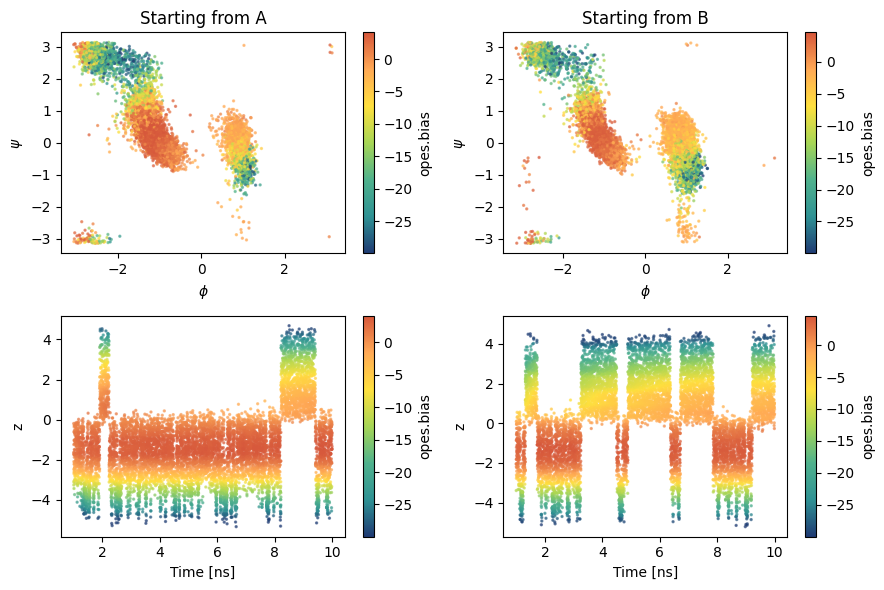

In [10]:
from mlcolvar.utils.io import load_dataframe

sampling = load_dataframe([f'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/biased_sims/iter_{iter}/A/COLVAR',
                           f'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/biased_sims/iter_{iter}/B/COLVAR'], 
                           start=1000)

fig, axs = plt.subplots(2,2,figsize=(9,6))

for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    ax.set_title(f'Starting from {s}')
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$\psi$')

    temp = sampling[sampling['walker'] == i] # we load one simulation per time
    cp = ax.scatter(temp['phi'], temp['psi'], c=temp['opes.bias'], cmap='fessa',s=2, alpha=0.6)
    cb = plt.colorbar(cp, ax=ax, label='opes.bias')
    cb.solids.set(alpha=1)
    
    ax = axs[1, i]
    ax.set_xlabel('Time [ns]')
    ax.set_ylabel('z')
    cp = ax.scatter(temp['time']/1000, temp['z.node-0'], c=temp['opes.bias'], cmap='fessa',s=2, alpha=0.6)
    cb = plt.colorbar(cp, ax=ax, label='opes.bias')
    cb.solids.set(alpha=1)

plt.tight_layout()
plt.show()

## Iter 1 and on
From iteration 1 we can incorporate in our dataset the new data we generated in the previous iterations and obtain a much better estimate for the committor.

The all code below can be copied and adapted for later iterations! You only need to change:
- The files to be loaded: the first two are always the same as they are for the boundary loss, the other change. At the beginning, when we are far from convergence and the model is still rough, it makes sense to **add** the new data to the previous training set. Later, as the model and the sampling improve, it is better to **replace** the existing data with the new ones.
- number of iteration `iter` if used in an automated fashion (advised)
- eventually the number of training epochs. If the dataset is not good yet, shorter traininings are ok (i.e., 1/20000 epochs). When the dataset looks solid and covers the whole space and you can see multiple tranisitions in the biased simulations, you can set longer trainings and aim for finer optimization (i.e., 2/40000 epochs)

#### Load data
Now we need to set `separate_boundary_dataset=True` and to fill the empty entries of the `dataframe['bias']` and `dataframe['opes.bias']` columns associated with the unbiased data

In [ ]:
filenames = ['https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/unbiased_sims/COLVAR_A',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/unbiased_sims/COLVAR_B',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/biased_sims/iter_0/A/COLVAR',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/biased_sims/iter_0/B/COLVAR',
            ]

load_args = [{'start' : 0, 'stop': 10000, 'stride': 5},
             {'start' : 0, 'stop': 10000, 'stride': 5},
             {'start' : 1000, 'stop': 10000, 'stride': 1}, # it is wise to discard a first transient part of OPES runs to use converged bias
             {'start' : 1000, 'stop': 10000, 'stride': 1}, # it is wise to discard a first transient part of OPES runs to use converged bias
            ]           

# load data
dataset, dataframe = create_dataset_from_files(file_names = filenames,
                                               create_labels = True,
                                               filter_args={'regex' : 'p[1-9]\.[abc]|p[1-2][0-9]\.[abc]'},
                                               return_dataframe = True,
                                               load_args=load_args,
                                               verbose = True)


# get bias
dataframe = dataframe.fillna({'opes.bias': 0, 'bias' : 0})
bias = torch.Tensor(dataframe['opes.bias'].values + dataframe['bias'].values)

# compute weights
dataset = compute_committor_weights(dataset=dataset, 
                                    bias=bias, 
                                    data_groups=[0, 1, 2, 3], 
                                    beta=beta)

# This makes the computation much faster and less memory consuming.
# 1. We compute the input descriptors and update the dataset --> smart_dataset
# 2. we precompute their derivatives wrt positions --> smart_derivatives
smart_derivatives = SmartDerivatives()
smart_dataset = smart_derivatives.setup(dataset=dataset,
                                        descriptor_function=ComputeDistances,
                                        n_atoms=n_atoms,
                                        separate_boundary_dataset=True, # here we keep it as false as we only have boundary data
                                        descriptors_batch_size=None      # the computation of descriptors and derivatives can also be done in batches
                                      )

# initialize datamodule
datamodule = DictModule(smart_dataset, lengths=[1])

Class 0 dataframe shape:  (2000, 91)
Class 1 dataframe shape:  (2000, 91)
Class 2 dataframe shape:  (9000, 102)
Class 3 dataframe shape:  (9000, 102)

 - Loaded dataframe (22000, 102): ['time', 'phi', 'psi', 'theta', 'ene', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'p1.a', 'p1.b', 'p1.c', 'p2.a', 'p2.b', 'p2.c', 'p3.a', 'p3.b', 'p3.c', 'p4.a', 'p4.b', 'p4.c', 'p5.a', 'p5.b', 'p5.c', 'p6.a', 'p6.b', 'p6.c', 'p7.a', 'p7.b', 'p7.c', 'p8.a', 'p8.b', 'p8.c', 'p9.a', 'p9.b', 'p9.c', 'p10.a', 'p10.b', 'p10.c', 'cell.ax', 'cell.ay', 'cell.az', 'cell.bx', 'cell.by', 'cell.bz', 'cell.cx', 'cell.cy', 'cell.cz', 'walker', 'labels', 'z.node-0', 'z.bias-0', 'q', 'bias', '@64.bias', '@64.bias_bias', 'opes.bias', 'opes.rct', 'opes.zed', 'opes

/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/data/datamodule.py:133: UserWarning: A torch.generator was provided but it is not used with random_split=False
  warnings.warn(


#### Visualize training set

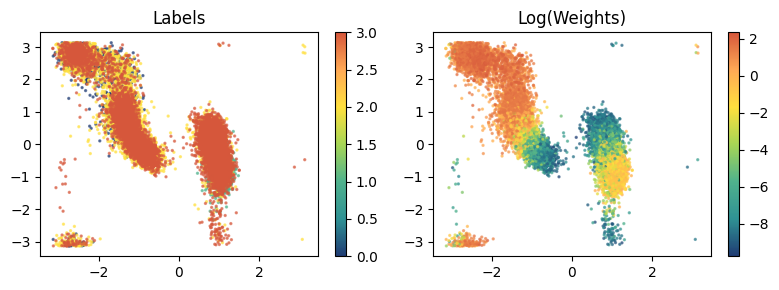

In [12]:
from mlcolvar.utils.plot import paletteFessa

fig, axs = plt.subplots(1,2,figsize=(8,3))

# plot labels
ax = axs[0]
ax.set_title('Labels')
cp = ax.scatter(dataframe['phi'], dataframe['psi'], c=dataset['labels'], cmap='fessa', s=2, alpha=0.6)
cb = plt.colorbar(cp, ax=ax)
cb.solids.set(alpha=1)

# plot weights
ax = axs[1]
ax.set_title('Log(Weights)')
cp = ax.scatter(dataframe['phi'], dataframe['psi'], c=torch.log(dataset['weights']), cmap='fessa', s=2, alpha=0.6)
cb = plt.colorbar(cp, ax=ax)
cb.solids.set(alpha=1)

plt.tight_layout()
plt.show()

#### Initialize model
Now we need to set `separate_boundary_dataset=True`

In [ ]:
# initialize lr scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR

# create options dictionary
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}, 
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.9999 },
            'nn' : {'activation' : 'tanh'}}

# initialize model
model = Committor(layers=[45, 32, 32, 1],
                         atomic_masses=atomic_masses,
                         alpha=1e1,
                         options=options, 
                         separate_boundary_dataset=True,            # this to separate dataset, by default True
                         descriptors_derivatives=smart_derivatives  # this makes the calculation of the variational loss faster
                         )

# copy the last layer sigmoid activation function so we can enable/disable it
Sigmoid = copy.copy(model.sigmoid)

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'descriptors_derivatives' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['descriptors_derivatives'])`.


#### Train model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type           | Params | In sizes | Out sizes
------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | ?        | ?        
1 | nn      | FeedForward    | 2.6 K  | [1, 45]  | [1, 1]   
2 | sigmoid | Custom_Sigmoid | 0      | [1, 1]   | [1, 1]   
------------------------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20000` reached.


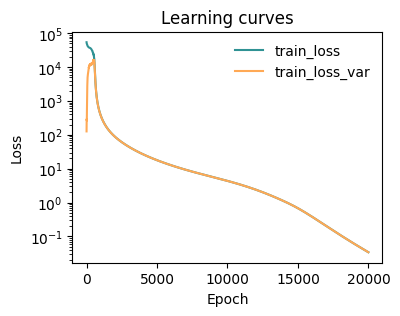

In [ ]:
# define callbacks
metrics = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath="./modelsave/", 
                                      save_top_k=5, 
                                      monitor="train_loss_epoch", 
                                      every_n_epochs=50,
                                      save_weights_only=True  # this makes it faster but is less generic!
                                      )

# initialize trainer, for testing the number of epochs is low, change this to something like 2/400000
trainer = lightning.Trainer(callbacks=[metrics, checkpoint_callback], 
                            max_epochs=5, 
                            logger=False, 
                            enable_checkpointing=True, # disabling or softening checkpointing could make it faster
                            limit_val_batches=0,    # this to skip validation
                            num_sanity_val_steps=0  # this to skip validation
                            )

# fit model
trainer.fit(model, datamodule)

# plot metrics
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1', 'fessa5'],
                  yscale='log',
                  ax = ax)

#### Visualize results

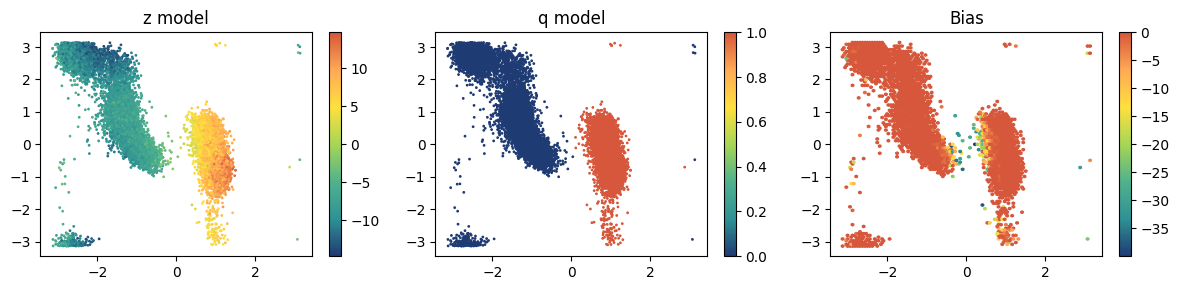

In [24]:
from mlcolvar.cvs.committor.utils import KolmogorovBias

fig, axs = plt.subplots(1,3,figsize=(12,3))

# plot z --> activation off, directly distances as inputs
model.sigmoid = None

ax = axs[0]
ax.set_title('z model')
aux = model(smart_dataset['data'])
cp = ax.scatter(dataframe['phi'], dataframe['psi'], c=aux.cpu().detach().numpy(), s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)


# plot q --> activation on, directly distances as inputs
model.sigmoid = Sigmoid

ax = axs[1]
ax.set_title('q model')
aux = model(smart_dataset['data'])
cp = ax.scatter(dataframe['phi'], dataframe['psi'],c=aux.cpu().detach().numpy(), s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)


# plot Kolmogorov bias --> activation on, distances as inputs as we do in PLUMED
model.sigmoid = Sigmoid

ax = axs[2]
ax.set_title('Bias')
bias_model = KolmogorovBias(model, lambd=2, beta=1)
aux = bias_model((smart_dataset['data']))
cp = ax.hexbin(dataframe['phi'], dataframe['psi'], C=aux.cpu().detach().numpy(), cmap='fessa')
plt.colorbar(cp, ax=ax)

plt.tight_layout()
plt.show()

#### Export trained model to torchscript

In [25]:
iter = 1

# turn of preprocessing as in PLUMED we precompute the descriptors to make it faster
model.preprocessing = None

# export z model --> activation off
model.sigmoid = None
model.to_torchscript(f'model_{iter}_z.pt', method='trace')
convert_model(f'model_{iter}_z.pt', 45)

# export q model --> activation on
model.sigmoid = Sigmoid
model.to_torchscript(f'model_{iter}_q.pt', method='trace')
convert_model(f'model_{iter}_q.pt', 45)

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/torch/jit/_trace.py:687: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


#### Check convergence of the model
One quick way to check the convergence of the iterative rpocedure is to compare the prediction of the current committor model with the previous one, at convergence they should be similar.

Here of course they are completely different! 

Class 0 dataframe shape:  (9000, 102)
Class 1 dataframe shape:  (9000, 102)

 - Loaded dataframe (18000, 102): ['time', 'phi', 'psi', 'theta', 'ene', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'p1.a', 'p1.b', 'p1.c', 'p2.a', 'p2.b', 'p2.c', 'p3.a', 'p3.b', 'p3.c', 'p4.a', 'p4.b', 'p4.c', 'p5.a', 'p5.b', 'p5.c', 'p6.a', 'p6.b', 'p6.c', 'p7.a', 'p7.b', 'p7.c', 'p8.a', 'p8.b', 'p8.c', 'p9.a', 'p9.b', 'p9.c', 'p10.a', 'p10.b', 'p10.c', 'cell.ax', 'cell.ay', 'cell.az', 'cell.bx', 'cell.by', 'cell.bz', 'cell.cx', 'cell.cy', 'cell.cz', 'z.node-0', 'z.bias-0', 'q', 'bias', '@64.bias', '@64.bias_bias', 'opes.bias', 'opes.rct', 'opes.zed', 'opes.neff', 'opes.nker', 'walker', 'labels']
 - Descriptors (18000, 30): ['p1.a', 'p1.b', 'p1.c', 

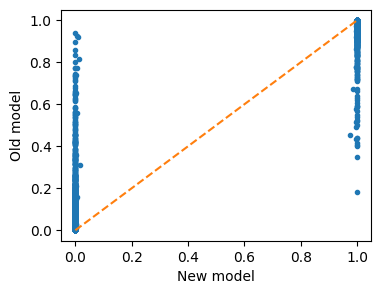

In [26]:
# load models
model_new = torch.jit.load(f'model_{iter}_q.pt').to(torch.float64)
model_old = torch.jit.load(f'model_{iter-1}_q.pt').to(torch.float64)

filenames = [f'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/biased_sims/iter_{iter-1}/A/COLVAR',
             f'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/biased_sims/iter_{iter-1}/B/COLVAR',
            ]

load_args = [{'start' : 1000, 'stop': 10000, 'stride': 1},
             {'start' : 1000, 'stop': 10000, 'stride': 1},
            ]           

# #######################################################################################

test_dataset, test_dataframe = create_dataset_from_files(file_names = filenames,
                                               create_labels = True,
                                               filter_args={'regex' : 'p[1-9]\.[abc]|p[1-2][0-9]\.[abc]'},
                                               return_dataframe = True,
                                               load_args=load_args,
                                               verbose = True)

pred_A = model_new(ComputeDistances(test_dataset['data'])).detach()
pred_B = model_old(ComputeDistances(test_dataset['data'])).detach()

# plot results
plt.figure(figsize=(4,3))
plt.plot(pred_A, pred_B, '.')
plt.xlabel('New model')
plt.ylabel('Old model')
# plot reference line
plt.plot( [0,1], [0, 1], ls='dashed')
plt.show()

#### Run plumed simulations
Here it is convient to create a submission script that updates the input file depending on the iteration you ar at and launches the simulations.

One good approach is to have a template simulation folder with all the inputs and then call the models, simulations folder etc. with progressive names based on the iterations. 
This way it is easy to write a script that depending on the iteration yuo are it changes the few parts that need to be changed in the input files.

For example:


`RUN_SIMULATION = f"cd biased_sims && bash generate_and_run_sims.sh {iter}"`

`subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash')`

#### Visualize sampling
We can see more transitions!

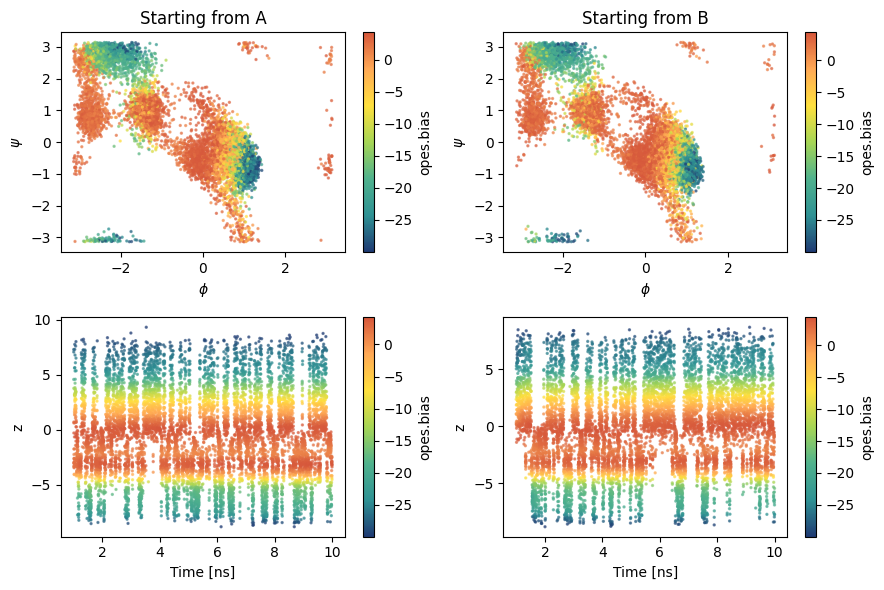

In [27]:
sampling = load_dataframe([f'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/biased_sims/iter_{iter}/A/COLVAR',
                           f'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/alanine/biased_sims/iter_{iter}/B/COLVAR'],
                           start=1000)

fig, axs = plt.subplots(2,2,figsize=(9,6))

for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    ax.set_title(f'Starting from {s}')
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$\psi$')
    temp = sampling[sampling['walker'] == i]
    cp = ax.scatter(temp['phi'], temp['psi'], c=temp['opes.bias'], cmap='fessa',s=2, alpha=0.6)
    cb = plt.colorbar(cp, ax=ax, label='opes.bias')
    cb.solids.set(alpha=1)
    
    ax = axs[1, i]
    ax.set_xlabel('Time [ns]')
    ax.set_ylabel('z')
    cp = ax.scatter(temp['time']/1000, temp['z.node-0'], c=temp['opes.bias'], cmap='fessa',s=2, alpha=0.6)
    cb = plt.colorbar(cp, ax=ax, label='opes.bias')
    cb.solids.set(alpha=1)
plt.tight_layout()
plt.show()